**Inspired on** https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

> Using the raw dataset instead (https://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions).

We'll be focusing on the WALKING activity.

In [1]:
import numpy as np
import pandas as pd
# from functools import reduce

data_location = '../datasets/uci-har-raw/'
data_location_raw = data_location + 'RawData/'
labels_of_interest = [1]

def extract(file, begin, end):
    partial_df = pd.read_csv(file, skipinitialspace=True, delim_whitespace=True, header=None)
    partial_df.columns = ['x', 'y', 'z']
    partial_df = partial_df.iloc[begin:end]

    return partial_df

def get_sensors_data(row):
    
    sensors = ['acc', 'gyro']
    frames = list()

    for sensor in sensors:
        file = data_location_raw + sensor + '_exp' + "{:02}".format(row['experiment']) + '_user' + "{:02}".format(row['user']) + '.txt'
        target = extract(file, row['begin'], row['end'] + 1)
        target.columns = [f'{sensor}_x', f'{sensor}_y', f'{sensor}_z']
        # Validation & segmentation purposes
        target[f'{sensor}_user'] = row['user']
        target[f'{sensor}_exp'] = row['experiment']
        frames.append(target)

    return frames[0].join(frames[1])

def run_experiment():
    
    labels_of_interest = [1]

    df_guide = pd.read_csv(data_location_raw + 'labels.txt', delim_whitespace=True, header=None)
    df_guide.columns = ['experiment', 'user', 'label', 'begin', 'end']

    df_target = df_guide[df_guide['label'].isin(labels_of_interest)]
    
    axis_df = pd.DataFrame()
    
    for index, row in df_target.iterrows():
        axis_df = axis_df.append(get_sensors_data(row), ignore_index=True, sort=False)
    
    axis_df['label'] = labels_of_interest[0]
    
    return axis_df

result = run_experiment()

### Dataset building

<AxesSubplot:xlabel='sac', ylabel='sgy'>

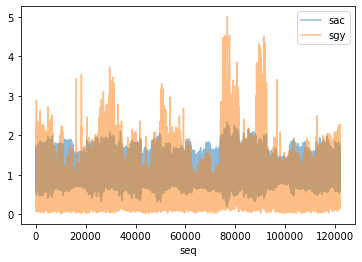

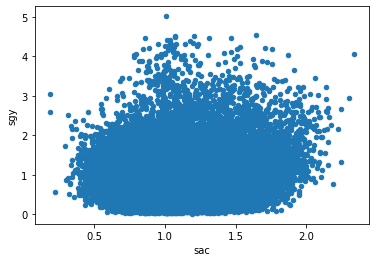

In [2]:
df_raw = result.copy()

df_raw.columns = ["acx", "acy", "acz", "acu", "ace", "gyx", "gyy", "gyz", "gyu", "gye", "label"]
# Cheap tri-axial accelerometer normalization
df_raw['sac'] = np.sqrt(np.power(df_raw['acx'], 2) + np.power(df_raw['acy'], 2) + np.power(df_raw['acz'], 2))
# Cheap tri-axial gyroscope normalization
df_raw['sgy'] = np.sqrt(np.power(df_raw['gyx'], 2) + np.power(df_raw['gyy'], 2) + np.power(df_raw['gyz'], 2))

df_raw.drop(["acx", "acy", "acz", "acu", "ace", "gyx", "gyy", "gyz"], axis=1, inplace=True)
df_raw.rename(columns = { 'gyu': 'user', 'gye': 'experiment' }, inplace=True)
df_raw['seq'] = pd.Index(range(df_raw.count()[0]))
df_raw.set_index(df_raw['seq'], drop=False)

df_raw.plot.line('seq', ['sac', 'sgy'], alpha=0.5)
df_raw.plot.scatter(x='sac', y='sgy')

## Train / Test set (TODO: validation missing.)

In [3]:
from keras.utils import to_categorical

def get_sets():
    X_train = df_raw[df_raw['user'].isin(range(1,22))]
    y_train = X_train['label']
    X_train.drop(['seq', 'label', 'user', 'experiment'], axis=1, inplace=True)

    X_test = df_raw[df_raw['user'].isin(range(22,31))]
    y_test = X_test['label']
    X_test.drop(['seq', 'label', 'user', 'experiment'], axis=1, inplace=True)

    trainy = y_train.values
    testy = y_test.values
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
	# one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)

    return X_train, trainy, X_test, testy

2022-06-16 20:00:29.129108: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-16 20:00:29.129196: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Windowing

Training and testing sets (`trainX` and `testX1`) will hold the raw data, packed into 1-second windows grouping 50 samples each.

LSTM requires three dimensions. Given these rules, we'll come up with one.

* 85100 total samples
* 1702 windows, each packing 1 sampled second
* Each normalized sernsor data will sit on a 3rd dimension

```
trainX.shape
(1702, 50, 2)

# Dimensionality organization:
# 1702 windows
# 50 samples (a second recordings at 50hz sampling)
# 2 features (Accelerometer (1) and Gyroscope(2) readings are normalized - dimensionality reduced - so `x, y, z axes` from each become a single one)
```

#### 2d & 3d are easier to visualize
The first one is is on a (x,y) like plane, while the other looks cube-like.

In [4]:

##
# A lot to optimize here, mostly for readability.
##

def windowed_chunks():
    trainX, trainy, testX, testy = get_sets()

    def chunker(seq, size):
        return (seq[pos:pos + size] for pos in range(0, len(seq), size))

    df_trainy = pd.DataFrame(data=trainy)

    dfr_trainy = list()
    for i in chunker(df_trainy,50):
        chunk_trainy = (i.iloc[0, 0])
        dfr_trainy.append(chunk_trainy)

    trainy = pd.DataFrame(data=dfr_trainy).values
    print(trainy.shape)

    df_testy = pd.DataFrame(data=testy)

    dfr_testy = list()
    for i in chunker(df_testy,50):
        chunk_testy = (i.iloc[0, 0])
        dfr_testy.append(chunk_testy)
        
    testy = pd.DataFrame(data=dfr_testy)
    print(testy.shape)
    
    df = pd.DataFrame(data=trainX, columns=['sac', 'sgy'])

    dfr = list()
    dfr2 = list()
    for i in chunker(df,50):
        chunk = (i['sac'].values)
        chunk2 = (i['sgy'].values)
        dfr.append(chunk)
        dfr2.append(chunk2)

    dfr = pd.DataFrame(data=dfr)
    dfr2 = pd.DataFrame(data=dfr2)
    print(dfr.shape)
    print(dfr2.shape)

    result = list()
    result.append(dfr.values)
    result.append(dfr2.values)

    trainX = np.dstack(result)
    print(trainX.shape)

    df_test = pd.DataFrame(data=testX, columns=['sac', 'sgy'])

    dfr_test = list()
    dfr2_test = list()
    for i in chunker(df_test,50):
        chunk_test = (i['sac'].values)
        chunk2_test = (i['sgy'].values)
        dfr_test.append(chunk_test)
        dfr2_test.append(chunk2_test)

    dfr_test = pd.DataFrame(data=dfr_test)
    dfr2_test = pd.DataFrame(data=dfr2_test)
    print(dfr_test.shape)
    print(dfr2_test.shape)

    result_test = list()
    result_test.append(dfr_test.values)
    result_test.append(dfr2_test.values)

    testX = np.dstack(result_test)
    print(testX.shape)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy


In [5]:
# TODO: optimize this block.

def un_windowed():

    trainX, trainy, testX, testy = get_sets()

    loaded_train = list()

    df_train = pd.DataFrame(trainX, columns=['sac', 'sgy'])

    sac_data = df_train.iloc[:,0].values
    loaded_train.append(sac_data)
    loaded_train_stack = dstack(loaded_train)

    sgy_data = df_train.iloc[:,1].values
    loaded_train.append(sgy_data)
    loaded_train_stack = dstack(loaded_train)

    trainX = loaded_train_stack

    loaded_test = list()

    df_test = pd.DataFrame(testX, columns=['sac', 'sgy'])

    sac_data = df_test.iloc[:,0].values
    loaded_test.append(sac_data)
    loaded_test_stack = dstack(loaded_test)

    sgy_data = df_test.iloc[:,1].values
    loaded_test.append(sgy_data)
    loaded_test_stack = dstack(loaded_test)

    testX = loaded_test_stack
    trainX = np.moveaxis(trainX, [1],[0])
    testX = np.moveaxis(testX, [1],[0])
    return trainX, trainy, testX, testy

## LSTM
Taken from *source*. Single line modification to build dataset from raw data instead of using the preprocessed option.

Source: https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

In [6]:
# lstm model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from matplotlib import pyplot

# [removed dataset loading code...]

# fit and evaluate a model

def evaluate_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 15, 64
	
	# n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

	model = Sequential()
	model.add(LSTM(100, input_shape=(n_timesteps,n_features), return_sequences=False))
	model.add(Dropout(0.5))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy

# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=10):
	# load data

	## LINE CHANGED ##
	trainX, trainy, testX, testy = windowed_chunks()

	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)

# run the experiment
run_experiment()

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(1702, 1)
(740, 1)
(1702, 50)
(1702, 50)
(1702, 50, 2)
(740, 50)
(740, 50)
(740, 50, 2)
(1702, 50, 2) (1702, 1) (740, 50, 2) (740, 1)


2022-06-16 20:00:31.664440: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-16 20:00:31.665139: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-16 20:00:31.665196: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d611bf5d73a5): /proc/driver/nvidia/version does not exist
2022-06-16 20:00:31.668225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


>#1: 99.865
>#2: 99.865
>#3: 99.865
>#4: 99.865
>#5: 99.865
>#6: 99.865
>#7: 99.865
>#8: 99.865
>#9: 99.865
>#10: 99.865
[99.86486434936523, 99.86486434936523, 99.86486434936523, 99.86486434936523, 99.86486434936523, 99.86486434936523, 99.86486434936523, 99.86486434936523, 99.86486434936523, 99.86486434936523]
Accuracy: 99.865% (+/-0.000)


### Conclusion
99.865% Accuracy with 0.00% Std. deviation. It smells!

This first step was to make it work with raw data (published during 2015) instead.

Things to work on now:

* We're focusing on WALKING, leaving aside all other labels (and relevant data).
* Windows overlapping and keeping dynamic to accomodate timing differences into training.
* Softmax and classification is used for a single category.
* Move into laterality analysis during a walk, and anomaly detection and fall prevention territory.
